In [1]:
import torch
import numpy as np

In [7]:
batch_size=1000
x_size=100
t_size=100
a=0
b=1
t0=0
t1=1

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,20)
        self.fc2 = nn.Linear(20,20)
        self.fc3 = nn.Linear(20,20) 
        self.fc4 = nn.Linear(20,20)
        self.fc5 = nn.Linear(20,20)
        self.fc6 = nn.Linear(20,20) 
        self.fc7 = nn.Linear(20,1)
        
        self.fc1d = nn.Linear(1,20)
        self.fc2d = nn.Linear(20,20)
        self.fc3d = nn.Linear(20,20) 
        self.fc4d = nn.Linear(20,20)
       
        self.fc1a = nn.Linear(20,20)
        self.fc2a = nn.Linear(20,20)
        self.fc3a = nn.Linear(20,20)
        self.fc4a = nn.Linear(20,1)
      


    def forward(self, x,t):
    
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))    
        
     
        
        t = F.softplus(self.fc1d(t))
        t = F.softplus(self.fc2d(t))          
             
        ans = x*t    
        ans = F.softplus(self.fc3a(ans))
        ans = F.softplus(self.fc4a(ans))
        
        return ans


net = Net()
net

Net(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=20, bias=True)
  (fc7): Linear(in_features=20, out_features=1, bias=True)
  (fc1d): Linear(in_features=1, out_features=20, bias=True)
  (fc2d): Linear(in_features=20, out_features=20, bias=True)
  (fc3d): Linear(in_features=20, out_features=20, bias=True)
  (fc4d): Linear(in_features=20, out_features=20, bias=True)
  (fc1a): Linear(in_features=20, out_features=20, bias=True)
  (fc2a): Linear(in_features=20, out_features=20, bias=True)
  (fc3a): Linear(in_features=20, out_features=20, bias=True)
  (fc4a): Linear(in_features=20, out_features=1, bias=True)
)

In [9]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [10]:
from torch.autograd import grad
x=torch.linspace(a, b, x_size,requires_grad=True,dtype=torch.float64).view(-1,1)
t=torch.linspace(t0, t1, t_size,requires_grad=True,dtype=torch.float64).view(-1,1)


for epoch in range(1000):
    optimizer.zero_grad()
    
    train_x=torch.rand((batch_size,1),requires_grad=True,dtype=torch.float)*(b-a)+a
    train_t=torch.rand((batch_size,1),requires_grad=True,dtype=torch.float)*(t1-t0)+t0   
 
    
    y_hat = net(train_x,train_t)           
    dy_dx_hat=grad(y_hat.sum(),train_x,allow_unused=True,retain_graph=True,create_graph=True)[0] 
    ddy_ddx_hat=grad(dy_dx_hat.sum(),train_x,allow_unused=True,retain_graph=True,create_graph=True)[0] 
    dy_dt_hat=grad(y_hat.sum(),train_t,allow_unused=True,retain_graph=True,create_graph=True)[0] 
    ddy_ddt_hat=grad(dy_dt_hat.sum(),train_t,allow_unused=True,retain_graph=True,create_graph=True)[0] 
    ddy_dxdt_hat=grad(dy_dx_hat.sum(),train_t,allow_unused=True,retain_graph=True,create_graph=True)[0]
    
    x0_train=torch.rand((x_size,1),requires_grad=True,dtype=torch.float)*(b-a)+a
    t0_train=torch.zeros((x_size,1),requires_grad=True)  
    y_init=x0_train  
    y_init_hat=net(x0_train,t0_train)
    dy_dt_init=torch.zeros(t_size,1)
    dy_dt_init_hat=grad(y_init_hat.sum(),t0_train,allow_unused=True,retain_graph=True,create_graph=True)[0] 
    
    x_a_train=torch.ones((t_size,1),requires_grad=True)*a
    t_a_train=torch.rand((t_size,1),requires_grad=True,dtype=torch.float)*(t1-t0)+t0  
    y_a=torch.zeros(t_size,1)
    y_a_hat=net(x_a_train,t_a_train)
    
    x_b_train=torch.ones((t_size,1),requires_grad=True)*b
    t_b_train=torch.rand((t_size,1),requires_grad=True,dtype=torch.float)*(t1-t0)+t0
    y_b=t_b_train**2+1
    y_b_hat=net(x_b_train,t_b_train)
    
    loss=nn.MSELoss()
    Loss=loss(ddy_dxdt_hat,2*train_t)+loss(y_init_hat,y_init)+loss(dy_dt_init_hat,dy_dt_init)+loss(y_a_hat,y_a)+loss(y_b_hat,y_b)
    Loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 99: 
        print('[%d], loss: %.10f'%(epoch+1,Loss.item()))

[100], loss: 0.0942412019
[200], loss: 0.0162986629
[300], loss: 0.0056856759
[400], loss: 0.0025121591
[500], loss: 0.0021685238
[600], loss: 0.0055318284
[700], loss: 0.0013319876
[800], loss: 0.0016025257
[900], loss: 0.0014486904
[1000], loss: 0.0013725789


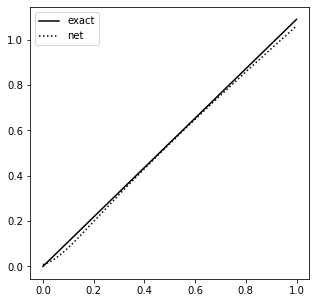

In [21]:
import matplotlib.pyplot as plt
def exact(x,t):
    return x*t**2+x

train_x=torch.linspace(a, b, batch_size).view(-1,1)
train_t=torch.ones((batch_size,1))*0.3



y=exact(train_x,train_t)
y_net=net(train_x,train_t)
plt.figure(figsize=(5, 5))
plt.plot(train_x.detach().numpy(),y.detach().numpy(),'k-',label="exact")
plt.plot(train_x.detach().numpy(),y_net.detach().numpy(),'k:',label="net") 
plt.legend ()